In [1]:
import numpy as np
import os
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# parameters
task = "visual"
artificial_delays = True
shared_delays = False
n_comp = 10
subsample = None

In [6]:
# get results from MVICAD
if artificial_delays:
    artificial_name = "_artificial_"
else:
    artificial_name = "_"
if shared_delays:
    shared_name = ""
else:
    shared_name = "multiple_"
if subsample:
    subsample_name = "_subsample" + str(subsample)
else:
    subsample_name = ""
algo = "mvicad_" + task + artificial_name + shared_name + "p" + str(n_comp) + subsample_name
save_path = "/storage/store2/work/aheurteb/mvicad/mlsp_results/%s/" % algo

# W_list
file_name = save_path + "W.npy"
if os.path.isfile(file_name):
    with open(file_name, "rb") as save_W_file:
        W_list = np.load(save_W_file)
else:
    print("W_list not found\n")

# tau_list
file_name2 = save_path + "tau_list.npy"
if os.path.isfile(file_name2):
    with open(file_name2, "rb") as save_delays_file:
        tau_list = np.load(save_delays_file)
else:
    print("tau_list not found\n")

# subjects if subsample
if subsample is not None:
    file_name3 = save_path + "subjects.npy"
    if os.path.isfile(file_name3):
        with open(file_name3, "rb") as save_subjects_file:
            subjects = np.load(save_subjects_file)
    else:
        print("subjects not found\n")

mvicad_visual_artificial_multiple_p10


In [8]:
# load dataset
dataset_path = "/storage/store2/work/aheurteb/mvicad/data/"

if task == "visual":
    ages = np.load(dataset_path + "ages_visual_task_477.npy")
    if artificial_delays:
        if shared_delays:
            X_name = "X_visual_task_mag_477_artificially_delayed.npy"
        else:
            X_name = "X_visual_task_mag_477_artificially_delayed_multiple.npy"
    else:
        X_name = "X_visual_task_mag_477.npy"
elif task == "auditory":
    if artificial_delays:
        if shared_delays:
            X_name = "X_auditory_task_mag_501_artificially_delayed.npy"
        else:
            X_name = "X_auditory_task_mag_501_artificially_delayed_multiple.npy"
    else:
        X_name = "X_auditory_task_mag_501.npy"
else:
    raise ValueError("Wrong task name")

data = np.load(dataset_path + X_name)
if subsample is not None:
    data = data[subjects]
    ages = ages[subjects]

# preprocessing : PCA
if artificial_delays and not shared_delays:
    X = data
else:
    X = []
    for d in tqdm(data):
        _, D, v = np.linalg.svd(d, full_matrices=False)
        y = v[:n_comp]
        x = y * D[:n_comp, None]
        X.append(x)
    X = np.array(X)
m, _, n = X.shape
print(X.shape)

(477, 10, 701)


In [9]:
# modify delays
tau_list[tau_list > n // 2] -= n

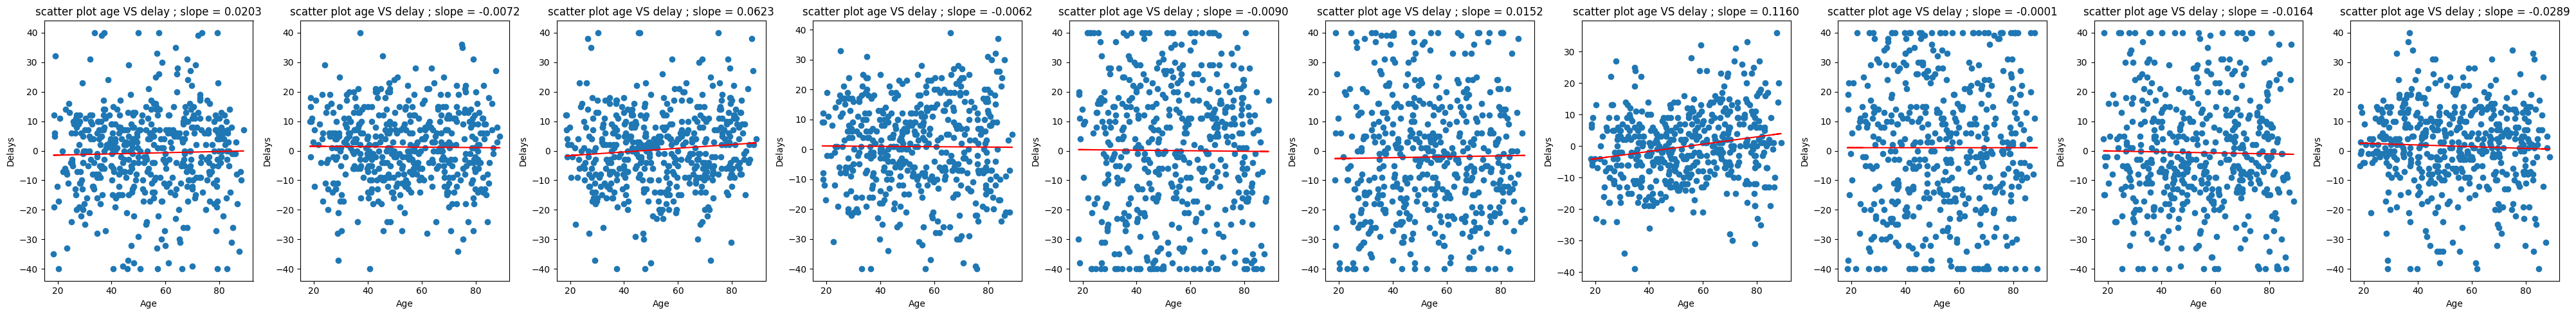

In [20]:
# function that plots the scatter plot age / delays for a specific source
def scatter_plot_age_delay(ages, delays, axis=None, title="scatter plot age VS delay"):
   # Linear regression
   slope, intercept, _, _, _ = stats.linregress(ages, delays)
   fitLine = slope * ages + intercept
   
   # Scatter plot age delays
   if axis is None:
        f, axis = plt.subplots()

   axis.scatter(ages, delays)
   axis.plot(ages, fitLine, c='r')
   axis.set_xlabel("Age")
   axis.set_ylabel("Delays")
   axis.set_title("{} ; slope = {:.4f}".format(title, slope));

# scatter plot age delay
if shared_delays:
    scatter_plot_age_delay(ages, tau_list)
else:
    f, axes = plt.subplots(1, n_comp, figsize=(4*n_comp, 5))
    for i in range(n_comp):
        scatter_plot_age_delay(ages, tau_list[:, i], axes[i])
    plt.tight_layout();

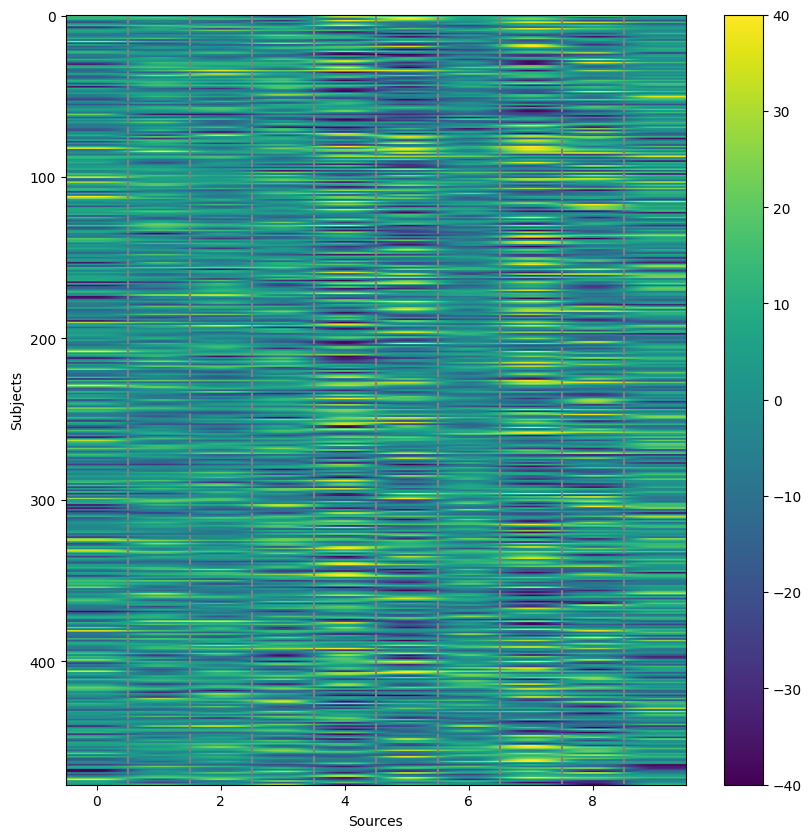

In [41]:
# heat map when using source-specific delays
if not shared_delays:
    plt.figure(figsize=(10, 10))
    plt.imshow(tau_list, aspect='auto')
    for i in range(n_comp-1):
        plt.vlines(x=i+0.5, ymin=0, ymax=len(tau_list)-1, colors='grey', linestyles='--')
    plt.colorbar()
    plt.xlabel("Sources")
    plt.ylabel("Subjects")

sources variance :  [222.71556593 151.7193149  171.83355968 220.5827389  512.50101745
 414.11039472 128.04180566 512.18306238 354.32870535 200.21209604]


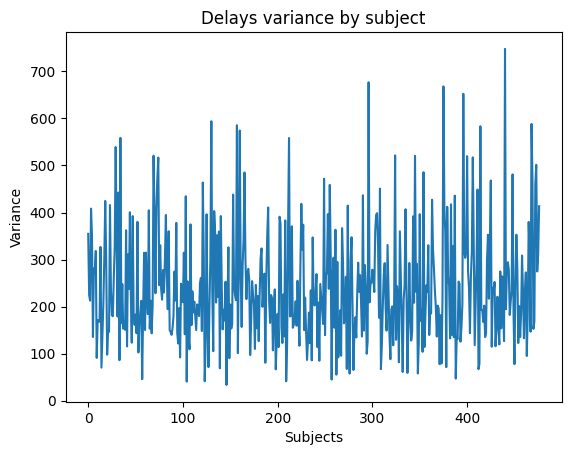

In [36]:
# variance when using source-specific delays
if not shared_delays:
    print("sources variance : ", np.var(tau_list, axis=0))
    plt.plot(np.var(tau_list, axis=1))
    plt.xlabel("Subjects")
    plt.ylabel("Variance")
    plt.title("Delays variance by subject");